In [1]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')


from math import sqrt
import pandas as pd

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [2]:
from clsar.dataset import LSSInhibitor # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACNet_GCN, ACNet_GIN, ACNet_GAT, ACNet_PNA # model

In [3]:
dataset_name = 'mth1'
Dataset =  LSSInhibitor # MoleculeNet
epochs = 500

pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '../../tmp/data1'

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

batch_size = 16

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
train_dataset

MTH1(28)

In [4]:
## 4 kind of models
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1,
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.2, 'batch_norms':None}

model_1 = ACNet_GCN(**pub_args).to(device)

model_2 = ACNet_GIN(**pub_args, eps = 0.0, train_eps = False).to(device)

model_3 = ACNet_GAT(**pub_args, dropout = 0.1, heads=3).to(device)

model_4 = ACNet_PNA(**pub_args, aggregators = ['mean', 'max', 'sum'],
                    scalers = ['identity', 'amplification'], 
                    deg = torch.tensor([1, 2, 3]),
                   ).to(device)

In [5]:
res = {}
for model, name in zip([model_1, model_2, model_3, model_4],['ACNet_GCN', 'ACNet_GIN', 'ACNet_GAT', 'ACNet_PNA']):

    print(name, '#'*50)
    
    def train():
        total_loss = total_examples = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
            total_examples += data.num_graphs
        return sqrt(total_loss / total_examples)

    @torch.no_grad()
    def test(loader):
        mse = []
        for data in loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
            mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        return float(torch.cat(mse, dim=0).mean().sqrt())

    optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                                 weight_decay=10**-5)
    history = []
    for epoch in range(1, epochs):
        train_rmse = train()
        val_rmse = test(val_loader)
        test_rmse = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
              f'Test: {test_rmse:.4f}')

        history.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
        
    print('\n')
    res.update({name:history})

ACNet_GCN ##################################################
Epoch: 001, Loss: 9.1668 Val: 8.9786 Test: 8.2090
Epoch: 002, Loss: 7.8775 Val: 7.4941 Test: 7.0644
Epoch: 003, Loss: 6.2399 Val: 5.7719 Test: 4.4351
Epoch: 004, Loss: 4.3077 Val: 3.9315 Test: 4.3022
Epoch: 005, Loss: 3.2806 Val: 3.5478 Test: 3.6452
Epoch: 006, Loss: 2.6906 Val: 2.7312 Test: 2.7618
Epoch: 007, Loss: 3.0294 Val: 2.5154 Test: 2.8304
Epoch: 008, Loss: 3.0302 Val: 3.3942 Test: 3.3851
Epoch: 009, Loss: 3.1096 Val: 3.1921 Test: 3.0779
Epoch: 010, Loss: 3.6086 Val: 2.4609 Test: 3.8005
Epoch: 011, Loss: 3.4678 Val: 2.9322 Test: 2.5021
Epoch: 012, Loss: 3.2142 Val: 2.7893 Test: 2.5328
Epoch: 013, Loss: 2.6353 Val: 2.5122 Test: 2.5985
Epoch: 014, Loss: 2.2873 Val: 2.6418 Test: 2.6273
Epoch: 015, Loss: 2.1814 Val: 2.8993 Test: 2.2220
Epoch: 016, Loss: 2.3633 Val: 2.8283 Test: 2.4205
Epoch: 017, Loss: 2.2080 Val: 3.1842 Test: 2.2793
Epoch: 018, Loss: 2.2569 Val: 3.0955 Test: 2.4936
Epoch: 019, Loss: 2.2221 Val: 2.8739 Te

In [6]:
import pandas as pd
df = pd.DataFrame(res)

test_rmse = pd.concat(df.apply(lambda x:x.apply(pd.Series).test_rmse.to_frame(name = x.name), axis=1).to_list(), axis=1).T
val_rmse = pd.concat(df.apply(lambda x:x.apply(pd.Series).val_rmse.to_frame(name = x.name), axis=1).to_list(), axis=1).T

<AxesSubplot:>

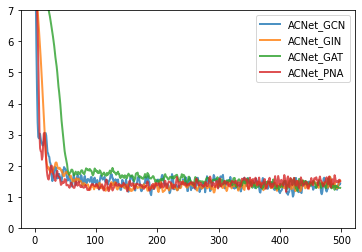

In [7]:
val_rmse.rolling(3).mean().plot(ylim = (0,7), lw=2, alpha=0.8)

<AxesSubplot:>

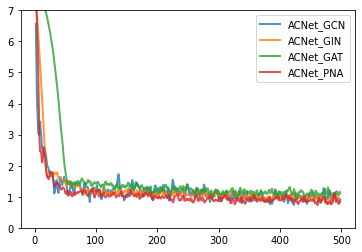

In [8]:
test_rmse.rolling(3).mean().plot(ylim = (0,7), lw=2, alpha=0.8)

In [15]:
for data in train_loader:
    data = data.to(device)
    
out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)

In [17]:
model.forward()

ACNet_PNA(
  (convs): ModuleList(
    (0): PNAConv(115, 64, towers=1, edge_dim=10)
    (1): PNAConv(64, 64, towers=1, edge_dim=10)
  )
  (jk): JumpingKnowledge(cat)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
model.forward(data.x.float(), data.edge_index, data.edge_attr, data.batch)

tensor([[10.4006],
        [ 7.6591],
        [ 7.2080],
        [ 7.5510],
        [ 5.3947],
        [ 7.5859],
        [ 8.3549],
        [ 6.5109],
        [ 8.2534],
        [ 5.8661],
        [ 6.4061],
        [ 7.8491]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
model.register_forward_hook()

tensor([[10.0000],
        [ 6.1600],
        [ 6.7000],
        [ 8.3000],
        [ 5.4300],
        [ 7.0800],
        [ 8.7400],
        [ 7.2800],
        [ 8.3000],
        [ 5.5200],
        [ 5.2400],
        [ 8.5100]], device='cuda:0')

In [38]:

embed = {}
def get_embed(name):
    def hook(model, input, output):
        embed[name] = output.detach()
    return hook

model.jk.register_forward_hook(get_embed('jk'))

In [39]:
embed

{}

In [36]:
data.x.shape

torch.Size([211, 115])

tensor([[10.3559],
        [ 8.0633],
        [ 8.0353],
        [ 8.4600],
        [ 4.9906],
        [ 8.5008],
        [ 8.4812],
        [ 7.3620],
        [ 7.8305],
        [ 5.7876],
        [ 6.6205],
        [ 8.4481]], device='cuda:0', grad_fn=<AddmmBackward0>)